In [194]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

### Positionwise Feed-Forward Networks
transformer架構為兩層MLP的架構

`用途: `  
"加強單詞的representation能力" 
1. 透過將feature投射到high dim,再投射到low dim, 過程中可以學習到更多抽象特徵, 加強單詞的representation能力  
2. 參考SVM, 將複雜的問題投射到高維空間, 使問題可以透過一個超平面解決, FFN將信息投射到高維空間, 空間中的各類信息更容易被區別
3. self-attention只在做不同的linear transform, 加入non-linear的方式, 可以提升單詞的repersentation能力


`formula: `  
<center>$FFN(x)=ReLU(xW_1+b_1)W_2+b_2$  </center>  

`reference: `  
https://blog.csdn.net/weixin_42399993/article/details/121585747
https://zhuanlan.zhihu.com/p/47510705

In [195]:
class PositionWiseFFN(nn.Module):  #@save
    """Positionwise feed-forward network."""
    def __init__(self,in_feature, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        '''
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)   
        '''
        self.dense1 = nn.Linear(in_feature,ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens,ffn_num_outputs)   

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

same MLP transformation on all position, when iputs are the same, their output are also identical.

In [197]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.0476,  0.3497, -0.7931,  0.6175,  0.2313,  0.2722, -0.0420,  0.5151],
        [-0.0476,  0.3497, -0.7931,  0.6175,  0.2313,  0.2722, -0.0420,  0.5151],
        [-0.0476,  0.3497, -0.7931,  0.6175,  0.2313,  0.2722, -0.0420,  0.5151]],
       grad_fn=<SelectBackward0>)

### Residual Connection and Layer Normalization  
`add: `其中add的部分參考至Resnet的shortcut概念,將input與attention output相加  
`norm: `batch normalization與layer nomalization計算公式相同,如下  
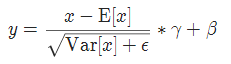   
$\epsilon$用作保證數值穩定, 分母不能為零會趨近於零,默認1e-5  
$\beta, \gamma$當需要做affine transformation  
BN, LN兩者差別在於input data不同, BN是對一個特徵維度做normalization, LN是對一個樣本(不同特徵)做normalization, BN多用在computer version, 而LN在NLP任務有較好的效果, 其一原因在於input經常是不固定變量大小

In [198]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from X in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [199]:
class AddNorm(nn.Module):  #@save
    """Residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [200]:
add_norm = AddNorm(4, 0.5)
d2l.check_shape(add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))), (2, 3, 4))

### encoder
---
`architecture: `  
1. muti-head attention mechanism + add&norm
2. positionwise FFN + add&norm

In [201]:
class TransformerEncoderBlock(nn.Module):  #@save
    """Transformer encoder block."""
    def __init__(self, in_feature, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(in_feature, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [202]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 24, 48, 8, 0.5)
#encoder_blk.eval()
#d2l.check_shape(encoder_blk(X, valid_lens), X.shape)

In [203]:
encoder_blk(X, valid_lens)

tensor([[[-0.1974,  0.3937, -1.4331,  ..., -1.5892,  0.4959, -0.3894],
         [-0.7591, -0.1553, -1.1588,  ...,  0.0253,  2.8838,  0.0253],
         [ 0.2700,  0.2738, -2.4242,  ..., -2.2335,  0.2700,  0.2700],
         ...,
         [ 0.0514,  0.0529, -0.7066,  ..., -0.5799,  0.9130, -0.8078],
         [ 0.5663,  0.0434,  0.0434,  ..., -0.8918,  0.0434, -0.7285],
         [ 0.1915,  0.0657,  0.0657,  ..., -2.1311,  2.5163,  0.0657]],

        [[ 0.7369,  0.1464, -1.6009,  ..., -0.6220,  0.2393,  0.9041],
         [-0.2658, -0.3012,  0.5146,  ..., -0.1373, -0.1373, -2.4799],
         [ 0.8642, -0.1884,  0.2405,  ..., -1.4813,  0.2405, -2.8578],
         ...,
         [ 0.3709,  0.1347, -0.9654,  ...,  0.3798,  0.3798, -1.3293],
         [-0.2459, -1.3437, -0.2459,  ...,  0.0685, -0.2459,  0.4137],
         [ 0.8396,  0.2937, -1.3307,  ...,  0.7828,  0.2937,  0.2150]]],
       grad_fn=<NativeLayerNormBackward0>)

In [204]:
class TransformerEncoder(d2l.Encoder):  #@save
    """Transformer encoder."""
    def __init__(self, vocab_size,in_feature, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                in_feature, num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up  
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens)) 
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [205]:
encoder = TransformerEncoder(200, 24, 24, 48, 8, 2, 0.5)
d2l.check_shape(encoder(torch.ones((2, 100), dtype=torch.long), valid_lens),
                (2, 100, 24))

### decoder
---
`architecture: `  
masked self-attention + add&norm  
encoder-decoder attention + add&norm  
positive FNN + add&norm


In [206]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self,in_feature, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(in_feature, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:

            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)   
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [207]:
decoder_blk = TransformerDecoderBlock(24, 24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
d2l.check_shape(decoder_blk(X, state)[0], X.shape)

In [208]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, in_feature, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                in_feature, num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [209]:
decoder = TransformerDecoder(200, 24, 24, 48, 8, 2, 0.5)
#d2l.check_shape(decoder(torch.ones((2, 100), dtype=torch.long), valid_lens),
#                (2, 100, 24))

In [210]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
state = [encoder_blk(X, valid_lens), valid_lens, [None,None]]
X = torch.ones((2, 100), dtype=torch.long)
valid_lens = torch.tensor([3, 2])
decoder(X,state)

(tensor([[[-0.5833,  1.1352,  0.0057,  ...,  0.0218,  0.1291,  0.1696],
          [-0.3445, -0.5433,  0.0424,  ..., -0.4518, -0.0971,  0.3113],
          [-0.0198,  0.5334,  0.2374,  ...,  0.3466, -0.4462, -0.1208],
          ...,
          [-0.8279,  0.0717,  0.0654,  ...,  0.1952, -1.3522, -0.8018],
          [-0.2872,  0.8361,  0.8865,  ..., -0.0118,  0.5298,  0.3098],
          [-0.5945,  0.4866, -0.0099,  ..., -0.3475, -0.6198,  0.0523]],
 
         [[ 0.3270,  0.1465, -0.0271,  ..., -1.0083,  0.1601, -0.5334],
          [-0.8169,  1.3483,  0.5375,  ..., -0.6480,  0.4912, -0.0910],
          [-0.2620,  0.0973,  0.0934,  ..., -0.8653,  0.5722, -0.1977],
          ...,
          [-1.1488,  0.6196, -0.5939,  ..., -0.9848,  0.5776, -0.1197],
          [-0.1079,  0.2461,  0.4102,  ..., -1.0398,  0.1925, -0.6541],
          [-0.6165,  0.0305,  0.0119,  ..., -0.7465,  0.0925, -0.0957]]],
        grad_fn=<ViewBackward0>),
 [tensor([[[-4.7892e-01,  2.0466e-01, -1.4733e+00,  ...,  2.0466e-0

training

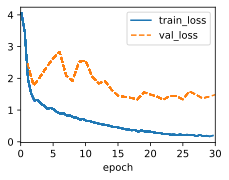

In [211]:
data = d2l.MTFraEng(batch_size=128)
in_feature = 256
num_hiddens, num_blks, dropout = 256, 4, 0.2
ffn_num_hiddens, num_heads = 512, 4
encoder = TransformerEncoder(
    len(data.src_vocab), in_feature, num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), in_feature, num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.0015)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [212]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ['je', "l'ai", 'fait', '.'], bleu,0.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


In [213]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0).reshape((num_blks, num_heads,
    -1, data.num_steps))
d2l.check_shape(enc_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

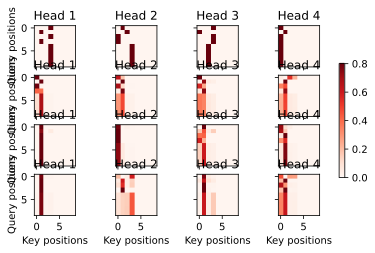

In [214]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [215]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weights
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_blks, num_heads, data.
    num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)

d2l.check_shape(dec_self_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))
d2l.check_shape(dec_inter_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

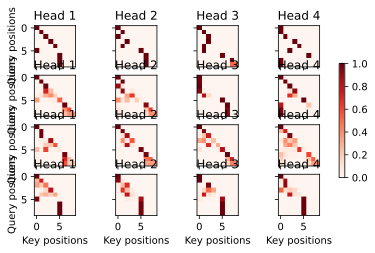

In [216]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

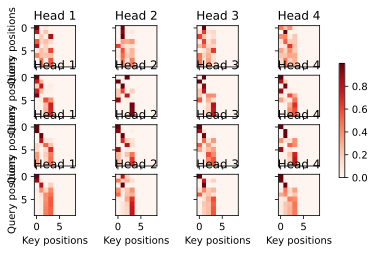

In [217]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

### summery
transformer是一個encoder-decoder的架構, encoder, decoder也可以獨立運行, 其中利用shortcut以及layer normalization方法能使model越疊越深, FFN對於序列的每個位置都使用相同的MLP 